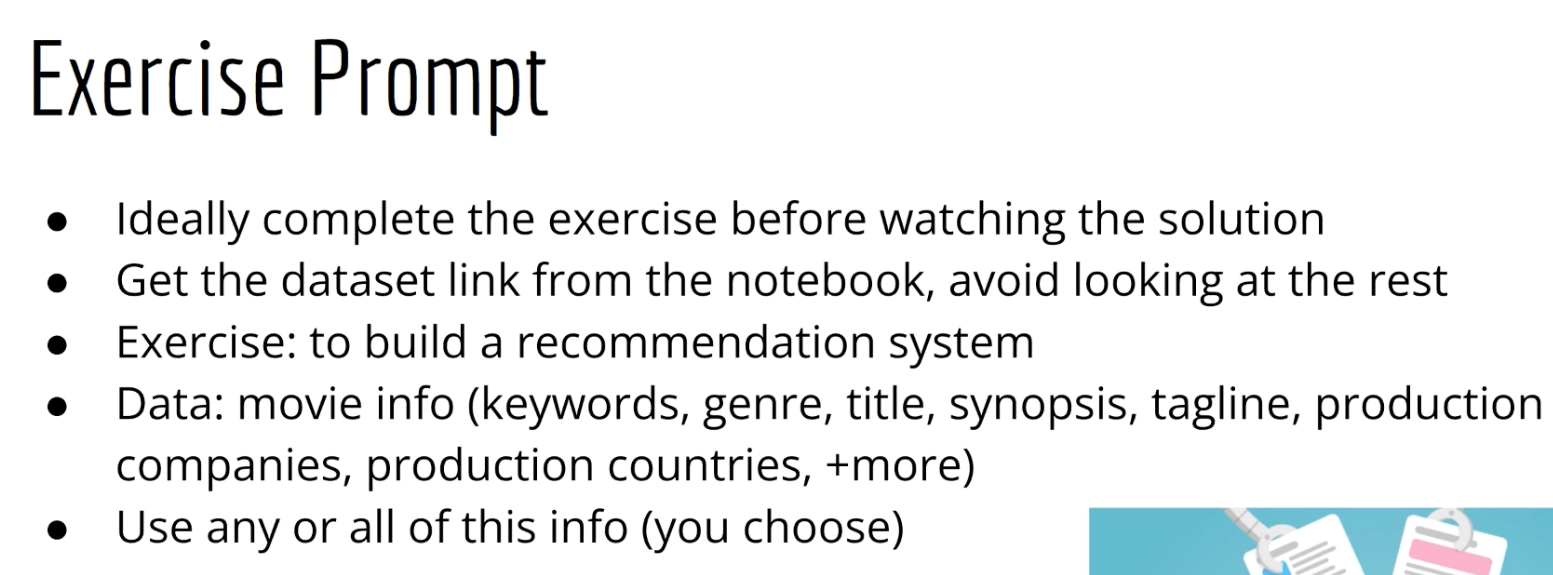

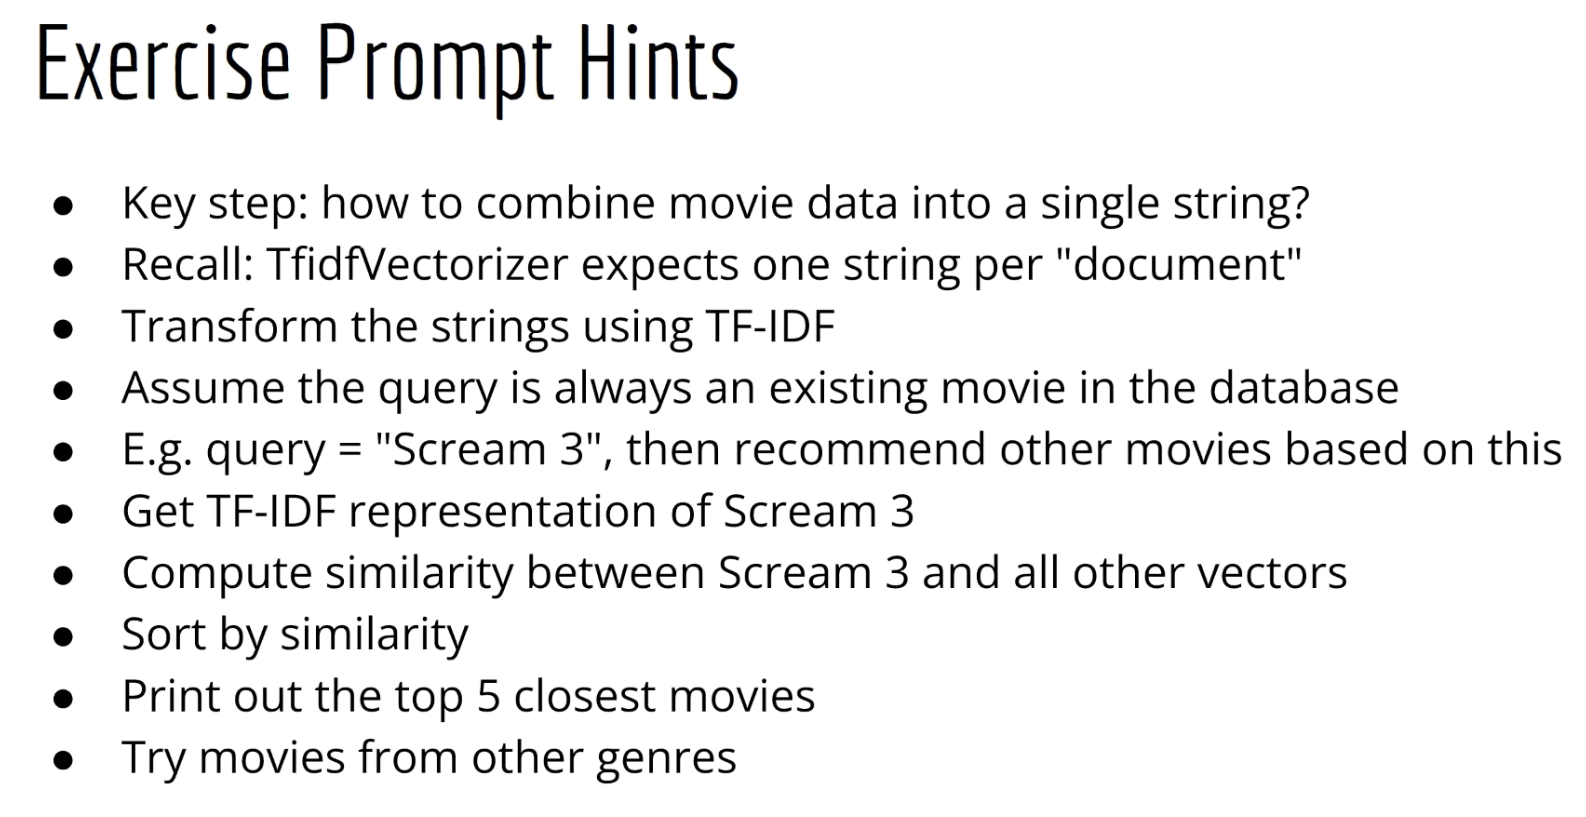

# Download the data

In [ ]:
%%bash
wget -nc -O data/tmdb_5000_movies.csv https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Read the data

In [ ]:
df = pd.read_csv("data/tmdb_5000_movies.csv")
df.head()

In [ ]:
df.iloc[3]

# Basic exploration

## Budget

In [ ]:
sns.histplot(df["budget"])

df["budget"].describe()

In [ ]:
df[df["budget"] == 0].head()
# Probably for some of the movies we are just missing the budget information. 0$ seems
# like a placeholder for missing data.

## Keywords

In [ ]:
# List all keywords
df_mod = df.copy()
df_mod["keyword_set"] = df["keywords"].apply(lambda x: {xi["name"] for xi in eval(x)})
df_mod["keyword_set"].head()

In [ ]:
sns.histplot(df_mod["keyword_set"].apply(len))
# Distribution of the number of keywords per movie

In [ ]:
# Get the total amount of unique keywords
unique_keywords = set()
for s in df_mod["keyword_set"]:
    unique_keywords.update(s)
print("Number of unique keywords:", len(unique_keywords))

# Count the number of times each keyword appears
genre_counts = {}
for s in df_mod["keyword_set"]:
    for keyword in s:
        genre_counts[keyword] = genre_counts.get(keyword, 0) + 1
genre_counts = pd.Series(genre_counts)
genre_counts.sort_values(ascending=False, inplace=True)
genre_counts.head(100)

## Overview

In [ ]:
is_not_str = np.where([not isinstance(row, str) for row in df["overview"]])[0].tolist()
display(df.iloc[is_not_str])  # noqa: F821
# We need to fill the missing values in the overview column with empty strings
df_mod["overview"] = df["overview"].fillna("")

In [ ]:
df_mod["overview"].map(len).describe()

## Genres

In [ ]:
df_mod["genres_set"] = df_mod["genres"].apply(lambda x: {xi["name"] for xi in eval(x)})
df_mod["genres_set"].head()

In [ ]:
sns.histplot(df_mod["genres_set"].apply(len))

In [ ]:
# Get the total amount of unique genres
unique_genres = set()
for s in df_mod["genres_set"]:
    unique_genres.update(s)
print("Number of unique genres:", len(unique_genres))

# Count the number of times each genre appears
genre_counts = {}
for s in df_mod["genres_set"]:
    for keyword in s:
        genre_counts[keyword] = genre_counts.get(keyword, 0) + 1
genre_counts = pd.Series(genre_counts)
genre_counts.sort_values(ascending=False, inplace=True)
genre_counts.head(100)

# Feature engineering

To build the search engine, I think we can focus on:
1. Genres
2. Overview
3. Keywords

#### Genres

There are only 20 genres. We can start by encoding them into a simple binary vector
encoding the genre of every movie.

In [ ]:
# We use a customized tokenizer. Each token is a genre. We can have genres with multiple
# words.
cvec_gens = CountVectorizer(tokenizer=lambda x: x.split(","), token_pattern=None)

# Get a comma separated list of genres for each movie
df_gens = df_mod["genres_set"].map(",".join).to_frame()

# For the training of the count vectorizer I am using only rows that have at least one
# genre. If a movie has no genre information, the resulting count vec encoding should
# be all zeros.
df_gens_train = df_gens.query("genres_set != ''")["genres_set"]
df_gens = df_gens["genres_set"]

# Fit the count vectorizer
cvec_gens.fit(df_gens_train.to_list())
assert len(cvec_gens.get_feature_names_out()) == len(unique_genres)
print(cvec_gens.get_feature_names_out())

# Encode all movies
X_gen = cvec_gens.transform(df_gens.to_list())
print(X_gen.shape)
print(X_gen.toarray())

# Ensure that movies with no genre information have all zeros in the encoding
assert np.all(X_gen[df_gens == ""].sum(axis=1).flatten() == 0)

#### Overview

The overview, or I guess somehow the summary of the movie, can be a good source for 
movie similarities. We use the TF-IDF encoding.

In [ ]:
tfidf_ovw = TfidfVectorizer(stop_words="english", strip_accents="ascii", norm=None)

df_ovw = df_mod["overview"]

X_ovw = tfidf_ovw.fit_transform(df_ovw)

print(tfidf_ovw.get_feature_names_out())
print(X_ovw.shape)
print(X_ovw[:10, :10].toarray())

#### Combination of keywords and genres

In [ ]:
df_mod["strings"] = df_mod.apply(
    lambda x: x["genres_set"].union(x["keyword_set"]), axis=1
)
df_mod.head()

tfidf_key_gen = TfidfVectorizer(
    tokenizer=lambda x: x.split(","), token_pattern=None, max_features=2000
)
X_key_gen = tfidf_key_gen.fit_transform(df_mod["strings"].map(",".join))

# Search engine

We build a simple search engine by using the cosine similarity between the vector 
encodings.

In the task we are asked to use the encoding of "Scream 3" to find top-5 
recommendations.

In [ ]:
def process_query(title_query):
    print("title:", title_query)
    s_query = df_mod.query(f"title == '{title_query}'")
    display(s_query)  # noqa: F821
    idx_query = s_query.index[0]
    print("index:", idx_query)

    return s_query, idx_query


_ = process_query("Avatar")

In [ ]:
def find_topk_idc(title_query, feat_x, k=5):
    _, idx_query = process_query(title_query)

    if isinstance(feat_x, list):
        sim = np.sum(
            [
                cosine_similarity(feat_xi, feat_xi[idx_query].reshape(1, -1)).flatten()
                for feat_xi in feat_x
            ],
            axis=0,
        )
        assert len(sim) == feat_x[0].shape[0]
    else:
        sim = cosine_similarity(feat_x, feat_x[idx_query].reshape(1, -1)).flatten()

    topk_idc = np.argsort(sim)[::-1][:k]
    topk_sim = sim[topk_idc]

    sns.histplot(sim, bins=100)

    return topk_idc, topk_sim

In [ ]:
top5_idc, top5_sim = find_topk_idc("Scream 3", X_gen, k=5)
print(top5_idc)
print(top5_sim)
display(df_mod.iloc[top5_idc])  # noqa: F821

In [ ]:
top5_idc, top5_sim = find_topk_idc("Scream 3", X_ovw, k=5)
print(top5_idc)
print(top5_sim)
display(df_mod.iloc[top5_idc])  # noqa: F821

In [ ]:
top5_idc, top5_sim = find_topk_idc("Scream 3", sp_sparse.hstack((X_ovw, X_gen)), k=5)
print(top5_idc)
print(top5_sim)
display(df_mod.iloc[top5_idc])  # noqa: F821

In [ ]:
top5_idc, top5_sim = find_topk_idc("Scream 3", [X_ovw, X_gen], k=5)
print(top5_idc)
print(top5_sim)
display(df_mod.iloc[top5_idc])  # noqa: F821

In [ ]:
top5_idc, top5_sim = find_topk_idc("Scream 3", X_key_gen, k=5)
print(top5_idc)
print(top5_sim)
display(df_mod.iloc[top5_idc])  # noqa: F821

In [ ]:
top5_idc, top5_sim = find_topk_idc("Avatar", X_key_gen, k=5)
print(top5_idc)
print(top5_sim)
display(df_mod.iloc[top5_idc])  # noqa: F821